In [1]:
import os
import time
import torch
import math
import torchvision
from torchvision import transforms as transforms
from torch import nn
from torch.nn import functional as F
from math import cos,pi

import matplotlib.pyplot as plt
import numpy as np
import random

torch.cuda.empty_cache()

In [2]:
torch.cuda.is_available()

True

In [3]:
torch.manual_seed(17)
torch.cuda.manual_seed_all(17)

aug_train = transforms.Compose([
    transforms.RandomCrop(32,padding=4,padding_mode='reflect'),
    transforms.RandomHorizontalFlip(), # 水平翻转
    transforms.ToTensor(),
    transforms.Normalize((0.4244, 0.4146, 0.3836), (0.2539, 0.2491, 0.2420)) # normalization
    ])

aug_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4244, 0.4146, 0.3836), (0.2539, 0.2491, 0.2420)) # normalization
    ])

trainingdata = torchvision.datasets.CIFAR10('./CIFAR10',train=True,download=True,transform=aug_train)
# testdata = torchvision.datasets.CIFAR10('./CIFAR10',train=False,download=True,transform=transforms.ToTensor())
# print(len(trainingdata),len(testdata))

Files already downloaded and verified


In [4]:
def load_data(is_train,aug,batch_size):
    dataset = torchvision.datasets.CIFAR10('./CIFAR10',train=is_train,download=True,transform=aug)
    dataloader = torch.utils.data.DataLoader(dataset,batch_size=batch_size,shuffle=is_train)
    return dataloader

batch_size = 128 # param
trainDataLoader = load_data(is_train=True,aug=aug_train,batch_size=batch_size)
testDataLoader = load_data(is_train=False,aug=aug_test,batch_size=batch_size)

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 32, 32]) 6


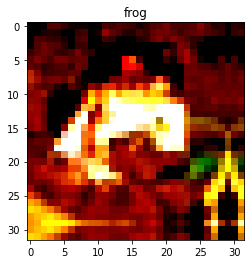

In [5]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

image,label = trainingdata[0]
print(image.shape, label)

%matplotlib inline
plt.imshow(image.numpy().transpose(1,2,0))
plt.title(str(classes[label]))
plt.show()

In [6]:
class BasicBlock(nn.Module):

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out



class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
#         self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(1024, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
#         print(x.shape)
        out = F.relu(self.bn1(self.conv1(x)))
#         print(out.shape)
        out = self.layer1(out)
#         print(out.shape)
        out = self.layer2(out)
#         print(out.shape)
        out = self.layer3(out)
#         print(out.shape)
#         out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
#         print(out.shape)
        out = out.view(out.size(0), -1)
#         print(out.shape)
        out = self.linear(out)
        return out
    
    def init_weights(self):
        for m in self.modules():
            if isinstance(m,nn.Conv2d):
                nn.init.kaiming_normal_(m.weight,mode='fan_out',nonlinearity='relu') # weight initialization
                if m.bias is not None:
                    nn.init.constant_(m.bias,0)
            elif isinstance(m,nn.BatchNorm2d):
                nn.init.constant_(m.weight,1)
                nn.init.constant_(m.bias,0)
            elif isinstance(m,nn.Linear):
                nn.init.normal_(m.weight,std=1e-3)
                if m.bias is not None:
                    nn.init.constant_(m.bias,0)

def project1_model():
#     return ResNet(BasicBlock, [2, 2, 2, 2])
    return ResNet(BasicBlock, [3, 3, 3])

# model1 = nn.Sequential(project1_model(), nn.AdaptiveAvgPool2d((1,1)), nn.Flatten(), nn.Linear(512, 10)).cuda()
model1 = project1_model().cuda()
model1.init_weights()

In [7]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    # torch.numel() returns number of elements in a tensor

print(count_parameters(model1))

4335434


In [8]:
# X = torch.rand(size=(1, 3, 32, 32)).cuda()
# for layer in model1:
#   X = layer(X)
#   print(layer.__class__.__name__,'output shape:\t', X.shape)

In [9]:
def adjust_learning_rate(optimizer, current_epoch,max_epoch,lr_min=0,lr_max=0.1,warmup=True):
    warmup_epoch = 10 if warmup else 0
    if current_epoch < warmup_epoch:
        lr = lr_max * current_epoch / warmup_epoch
    else:
        lr = lr_min + (lr_max-lr_min)*(1 + cos(pi * (current_epoch - warmup_epoch) / (max_epoch - warmup_epoch))) / 2
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [10]:
num_epochs = 500 # param
epoch_start = 0
path = 'resnet_aug_3block_sgd_warmup_consine_batch128_lr02.pt'

train_loss_history = []
test_loss_history = []
train_accuracy_history = []
test_accuracy_history = []

Loss = torch.nn.CrossEntropyLoss()

lr = 0.2
lr_min=0.001
momentum = 0.9
nesterov = True
optimizer = torch.optim.SGD(model1.parameters(),lr=lr,momentum=momentum,nesterov=nesterov)



if os.path.exists(path):
    checkpoint = torch.load(path)
    print('Read model from checkpoint')
    model1.cuda().load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch_start = checkpoint['epoch']
    Loss = checkpoint['Loss']
    train_loss_history = checkpoint['train_loss_history']
    test_loss_history = checkpoint['test_loss_history']
    train_accuracy_history = checkpoint['train_accuracy_history']
    test_accuracy_history = checkpoint['test_accuracy_history']
    print('Restart from epoch',epoch_start)
    

for epoch in range(epoch_start+1, num_epochs+1):
    timestart = time.time()

    train_loss = 0.0
    test_loss = 0.0
    train_accuracy = 0.0
    test_accuracy = 0.0

    for i, data in enumerate(trainDataLoader):
        images, labels = data
        images = images.cuda()
        labels = labels.cuda()
        optimizer.zero_grad()
        predicted_output = model1.cuda()(images)
        fit = Loss(predicted_output,labels)
        fit.backward()
        adjust_learning_rate(optimizer=optimizer,current_epoch=epoch,max_epoch=num_epochs,lr_min=lr_min,lr_max=lr,warmup=True)
        optimizer.step()
        train_loss += fit.item()
        train_accuracy += (torch.eq(torch.max(predicted_output,1)[1],labels).sum()/len(labels)*100).data.cpu().numpy()

    for i, data in enumerate(testDataLoader):
        with torch.no_grad():
            images, labels = data
            images = images.cuda()
            labels = labels.cuda()
            predicted_output = model1.cuda()(images)
            fit = Loss(predicted_output,labels)
            test_loss += fit.item()
            test_accuracy += (torch.eq(torch.max(predicted_output,1)[1],labels).sum()/len(labels)*100).data.cpu().numpy()


    train_loss = train_loss/len(trainDataLoader)
    test_loss = test_loss/len(testDataLoader)
    train_accu = train_accuracy/len(trainDataLoader)
    test_accu = test_accuracy/len(testDataLoader)
    train_loss_history.append(train_loss)
    test_loss_history.append(test_loss)
    train_accuracy_history.append(train_accu)
    test_accuracy_history.append(test_accu)
    print('Epoch %s, Train loss %s, Test loss %s, Train accuracy %s, Test accuracy %s, Cost %s s'%(epoch,
                                                                                                   train_loss,test_loss,
                                                                                                   train_accu,test_accu,
                                                                                                   time.time()-timestart))

    if epoch % 5 == 0 and epoch != 0:
        torch.save({'epoch':epoch,
          'model_state_dict':model1.cuda().state_dict(),
          'optimizer_state_dict':optimizer.state_dict(),
          'Loss':Loss,
          'train_loss_history':train_loss_history,
          'test_loss_history':test_loss_history,
          'train_accuracy_history':train_accuracy_history,
          'test_accuracy_history':test_accuracy_history},path)
        print('Model saved in epoch %s'%(epoch))

Epoch 1, Train loss 1.6415462801828409, Test loss 1.289737434326848, Train accuracy 41.883391953490275, Test accuracy 52.29430379746835, Cost 111.49244737625122 s
Epoch 2, Train loss 1.1088059440903042, Test loss 0.8508176471613631, Train accuracy 60.35605818414322, Test accuracy 70.02571202531645, Cost 110.59972143173218 s
Epoch 3, Train loss 0.8541915024942754, Test loss 0.7368170875537244, Train accuracy 69.83815537084399, Test accuracy 74.26819620253164, Cost 111.03025150299072 s
Epoch 4, Train loss 0.6997215584720797, Test loss 0.5835538155670408, Train accuracy 75.74848145780051, Test accuracy 79.89517405063292, Cost 111.5448989868164 s
Epoch 5, Train loss 0.5998320297511948, Test loss 0.5462043043933337, Train accuracy 79.21515345268543, Test accuracy 81.45767405063292, Cost 109.66526222229004 s
Model saved in epoch 5
Epoch 6, Train loss 0.5310878142371507, Test loss 0.5419430800631077, Train accuracy 81.84502877237851, Test accuracy 81.52689873417721, Cost 112.69448590278625 s


Epoch 50, Train loss 0.03067562281323211, Test loss 0.3238592488290388, Train accuracy 98.94301470588235, Test accuracy 92.48417721518987, Cost 109.15890407562256 s
Model saved in epoch 50
Epoch 51, Train loss 0.032532311546916375, Test loss 0.3619037216788606, Train accuracy 98.90505115089515, Test accuracy 92.2863924050633, Cost 111.92536449432373 s
Epoch 52, Train loss 0.030108696416370533, Test loss 0.35271448028993, Train accuracy 98.94661125319693, Test accuracy 92.52373417721519, Cost 113.11293005943298 s
Epoch 53, Train loss 0.03111408568535815, Test loss 0.3389663991954508, Train accuracy 98.92303388746804, Test accuracy 92.75118670886076, Cost 113.06783986091614 s
Epoch 54, Train loss 0.02888949738358102, Test loss 0.3157142313975322, Train accuracy 99.02054028132993, Test accuracy 92.88963607594937, Cost 114.03724098205566 s
Epoch 55, Train loss 0.024677851818837797, Test loss 0.33275316570755803, Train accuracy 99.13283248081841, Test accuracy 92.79074367088607, Cost 112.30

Epoch 99, Train loss 0.007113842927875197, Test loss 0.4018955878630469, Train accuracy 99.767023657289, Test accuracy 93.18631329113924, Cost 54.51024913787842 s
Epoch 100, Train loss 0.009661891805271551, Test loss 0.3993646165804018, Train accuracy 99.67631074168798, Test accuracy 93.19620253164557, Cost 54.535062074661255 s
Model saved in epoch 100
Epoch 101, Train loss 0.00841413753779444, Test loss 0.39237009847088705, Train accuracy 99.72826086956522, Test accuracy 93.2060917721519, Cost 54.38287115097046 s
Epoch 102, Train loss 0.008734015577161686, Test loss 0.3639364121835443, Train accuracy 99.71827046035806, Test accuracy 93.41376582278481, Cost 54.50287222862244 s
Epoch 103, Train loss 0.008869063437291666, Test loss 0.37319345828853073, Train accuracy 99.68789961636828, Test accuracy 93.3742088607595, Cost 54.38068675994873 s
Epoch 104, Train loss 0.007223855199962509, Test loss 0.39262208021894285, Train accuracy 99.74824168797954, Test accuracy 93.35443037974683, Cost 5

Epoch 147, Train loss 0.005201248371927168, Test loss 0.40091078652988504, Train accuracy 99.82816496163683, Test accuracy 93.6511075949367, Cost 54.458922147750854 s
Epoch 148, Train loss 0.003853274815622025, Test loss 0.42543356611004357, Train accuracy 99.88091432225065, Test accuracy 93.46321202531645, Cost 54.45367431640625 s
Epoch 149, Train loss 0.003548394256747653, Test loss 0.4253035545278388, Train accuracy 99.86812659846548, Test accuracy 93.38409810126582, Cost 54.364825963974 s
Epoch 150, Train loss 0.002956841849610959, Test loss 0.40832243190158773, Train accuracy 99.88810741687979, Test accuracy 93.52254746835443, Cost 54.37355995178223 s
Model saved in epoch 150
Epoch 151, Train loss 0.00202034522456071, Test loss 0.3971095365248149, Train accuracy 99.9380594629156, Test accuracy 93.76977848101266, Cost 54.46327614784241 s
Epoch 152, Train loss 0.0025331043000103985, Test loss 0.4197761374938337, Train accuracy 99.91408248081841, Test accuracy 93.88844936708861, Cost

Epoch 195, Train loss 0.0018207597192198576, Test loss 0.4775370791365829, Train accuracy 99.94005754475704, Test accuracy 93.5818829113924, Cost 54.5318067073822 s
Model saved in epoch 195
Epoch 196, Train loss 0.0014509871523673517, Test loss 0.46403002418294736, Train accuracy 99.96403452685422, Test accuracy 93.64121835443038, Cost 54.5071325302124 s
Epoch 197, Train loss 0.001156899512019619, Test loss 0.4791591466416287, Train accuracy 99.96403452685422, Test accuracy 93.73022151898734, Cost 54.52119183540344 s
Epoch 198, Train loss 0.0007790382725378982, Test loss 0.4654903696684898, Train accuracy 99.97202685421995, Test accuracy 93.79944620253164, Cost 54.513625621795654 s
Epoch 199, Train loss 0.000564675259547477, Test loss 0.48116517566804645, Train accuracy 99.9880115089514, Test accuracy 93.5818829113924, Cost 54.45139002799988 s
Epoch 200, Train loss 0.0009581181747471407, Test loss 0.4796980008294311, Train accuracy 99.96403452685422, Test accuracy 93.76977848101266, Co

Epoch 243, Train loss 0.0002208231452769019, Test loss 0.4808253646368467, Train accuracy 99.99600383631713, Test accuracy 93.87856012658227, Cost 54.388097047805786 s
Epoch 244, Train loss 0.0002253358781257446, Test loss 0.475274844307311, Train accuracy 99.99400575447571, Test accuracy 94.00712025316456, Cost 54.395986795425415 s
Epoch 245, Train loss 0.00030187884232356577, Test loss 0.47426407397547854, Train accuracy 99.99200767263427, Test accuracy 93.89833860759494, Cost 54.37939977645874 s
Model saved in epoch 245
Epoch 246, Train loss 0.0001670873433839291, Test loss 0.4826453380946872, Train accuracy 99.99800191815856, Test accuracy 93.97745253164557, Cost 54.36504411697388 s
Epoch 247, Train loss 0.00035495517074486064, Test loss 0.4843822478116313, Train accuracy 99.9880115089514, Test accuracy 94.11590189873418, Cost 54.44774150848389 s
Epoch 248, Train loss 0.0003466530315454397, Test loss 0.4791566022683548, Train accuracy 99.98201726342711, Test accuracy 94.07634493670

Epoch 291, Train loss 7.954604017885197e-05, Test loss 0.4915873743593693, Train accuracy 99.99600383631713, Test accuracy 93.9873417721519, Cost 54.56043577194214 s
Epoch 292, Train loss 3.417879236575181e-05, Test loss 0.4902926371256007, Train accuracy 100.0, Test accuracy 93.9873417721519, Cost 54.52001690864563 s
Epoch 293, Train loss 0.00017546759527631636, Test loss 0.49163320054642007, Train accuracy 99.99400575447571, Test accuracy 94.0565664556962, Cost 54.58946180343628 s
Epoch 294, Train loss 0.00023053475067957654, Test loss 0.4922050596981109, Train accuracy 99.99400575447571, Test accuracy 94.03678797468355, Cost 54.5405855178833 s
Epoch 295, Train loss 0.00013228105927571882, Test loss 0.4918537370954888, Train accuracy 99.99400575447571, Test accuracy 94.07634493670886, Cost 54.58902359008789 s
Model saved in epoch 295
Epoch 296, Train loss 7.301791402447123e-05, Test loss 0.49675387653368935, Train accuracy 99.99800191815856, Test accuracy 94.04667721518987, Cost 54.5

Epoch 341, Train loss 1.8349875472284094e-05, Test loss 0.48547861831191974, Train accuracy 100.0, Test accuracy 94.2246835443038, Cost 54.506897926330566 s
Epoch 342, Train loss 3.2254740269921906e-05, Test loss 0.48642979755620414, Train accuracy 100.0, Test accuracy 94.14556962025317, Cost 54.44251775741577 s
Epoch 343, Train loss 2.6711458294148815e-05, Test loss 0.48593991822739946, Train accuracy 100.0, Test accuracy 94.13568037974683, Cost 54.40131402015686 s
Epoch 344, Train loss 1.5740265700950108e-05, Test loss 0.4861414817079336, Train accuracy 100.0, Test accuracy 94.17523734177215, Cost 54.38767123222351 s
Epoch 345, Train loss 1.4631413315951188e-05, Test loss 0.4861342044240689, Train accuracy 100.0, Test accuracy 94.16534810126582, Cost 54.37610459327698 s
Model saved in epoch 345
Epoch 346, Train loss 2.548793713322433e-05, Test loss 0.48571917141162896, Train accuracy 100.0, Test accuracy 94.17523734177215, Cost 54.36529564857483 s
Epoch 347, Train loss 2.441776838488

Epoch 392, Train loss 2.734725065753788e-05, Test loss 0.48792973896370656, Train accuracy 100.0, Test accuracy 94.16534810126582, Cost 54.74587416648865 s
Epoch 393, Train loss 1.0304968976676444e-05, Test loss 0.4879613530975354, Train accuracy 100.0, Test accuracy 94.1554588607595, Cost 54.52417778968811 s
Epoch 394, Train loss 1.4332404888174528e-05, Test loss 0.4884301560777652, Train accuracy 100.0, Test accuracy 94.17523734177215, Cost 54.6549129486084 s
Epoch 395, Train loss 9.074306102460734e-06, Test loss 0.4884802341767693, Train accuracy 100.0, Test accuracy 94.18512658227849, Cost 54.554150342941284 s
Model saved in epoch 395
Epoch 396, Train loss 1.5460894986242084e-05, Test loss 0.48863063167922105, Train accuracy 100.0, Test accuracy 94.17523734177215, Cost 54.54179787635803 s
Epoch 397, Train loss 1.3752033099304921e-05, Test loss 0.4886321959356907, Train accuracy 100.0, Test accuracy 94.17523734177215, Cost 54.53444838523865 s
Epoch 398, Train loss 8.993604924335652e

Epoch 443, Train loss 1.2244070792870843e-05, Test loss 0.48943040997402953, Train accuracy 100.0, Test accuracy 94.19501582278481, Cost 54.522146701812744 s
Epoch 444, Train loss 2.1689712747173515e-05, Test loss 0.48939801390648263, Train accuracy 100.0, Test accuracy 94.19501582278481, Cost 54.58022952079773 s
Epoch 445, Train loss 9.494625540136656e-06, Test loss 0.4893965365223681, Train accuracy 100.0, Test accuracy 94.19501582278481, Cost 54.62420606613159 s
Model saved in epoch 445
Epoch 446, Train loss 7.335009927493796e-06, Test loss 0.48941533362988054, Train accuracy 100.0, Test accuracy 94.19501582278481, Cost 54.67685532569885 s
Epoch 447, Train loss 1.1318015198279125e-05, Test loss 0.4893890542532258, Train accuracy 100.0, Test accuracy 94.19501582278481, Cost 54.75720500946045 s
Epoch 448, Train loss 1.7591851157677964e-05, Test loss 0.48929101701448613, Train accuracy 100.0, Test accuracy 94.17523734177215, Cost 54.77629542350769 s
Epoch 449, Train loss 1.761976540880

Epoch 494, Train loss 7.160883802627532e-05, Test loss 0.48943302215701795, Train accuracy 99.99800191815856, Test accuracy 94.16534810126582, Cost 54.39414668083191 s
Epoch 495, Train loss 1.0515440849954383e-05, Test loss 0.48943672061579513, Train accuracy 100.0, Test accuracy 94.16534810126582, Cost 54.40138053894043 s
Model saved in epoch 495
Epoch 496, Train loss 9.489536318516516e-06, Test loss 0.48943427910061577, Train accuracy 100.0, Test accuracy 94.16534810126582, Cost 54.367151737213135 s
Epoch 497, Train loss 1.3277987930479198e-05, Test loss 0.4894315149470032, Train accuracy 100.0, Test accuracy 94.16534810126582, Cost 54.3585307598114 s
Epoch 498, Train loss 3.317548744751098e-05, Test loss 0.48948139935448953, Train accuracy 100.0, Test accuracy 94.16534810126582, Cost 54.3537757396698 s
Epoch 499, Train loss 1.7110420580873402e-05, Test loss 0.4894819913809247, Train accuracy 100.0, Test accuracy 94.16534810126582, Cost 54.358179569244385 s
Epoch 500, Train loss 1.88

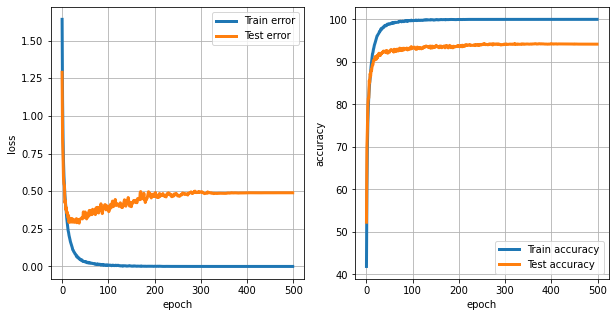

In [11]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(range(num_epochs),train_loss_history,'-',linewidth=3,label='Train error')
plt.plot(range(num_epochs),test_loss_history,'-',linewidth=3,label='Test error')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(num_epochs),train_accuracy_history,'-',linewidth=3,label='Train accuracy')
plt.plot(range(num_epochs),test_accuracy_history,'-',linewidth=3,label='Test accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.grid(True)
plt.legend()

In [12]:
print('Accuracy:',sum(test_accuracy_history[-5:])/5)

Accuracy: 94.16534810126582
